Using TensorFlow backend.


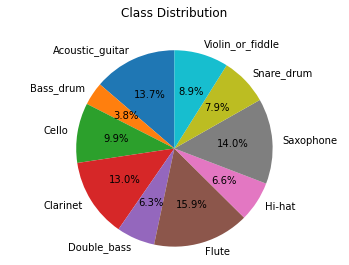

17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav
5388d14d.wav
229be2be.wav
d6144e01.wav
17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav
5388d14d.wav
229be2be.wav
d6144e01.wav
17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav
5388d14d.wav
229be2be.wav
d6144e01.wav
17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav
5388d14d.wav
229be2be.wav
d6144e01.wav
17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav
5388d14d.wav
229be2be.wav
d6144e01.wav
17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav
5388d14d.wav
229be2be.wav
d6144e01.wav
17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav
5388d14d.wav
229be2be.wav
d6144e01.wav
17f82c05.wav
52e54bdd.wav
e2d993ec.wav
a64a3740.wav
e6597186.wav
18865530.wav
078f7ac0.wav

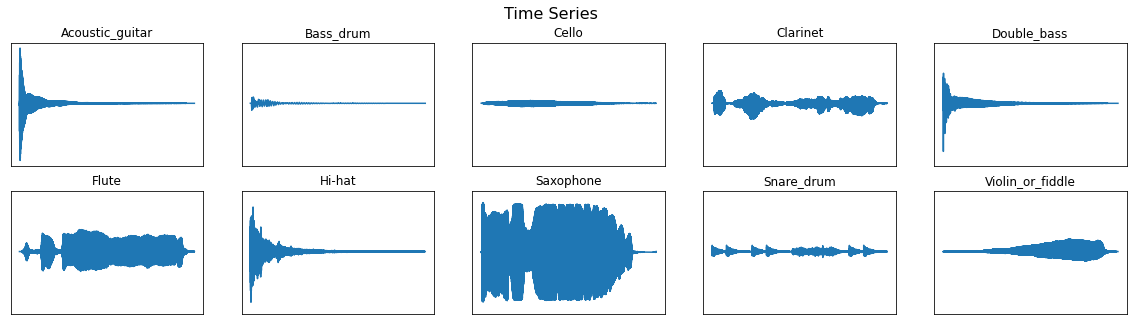

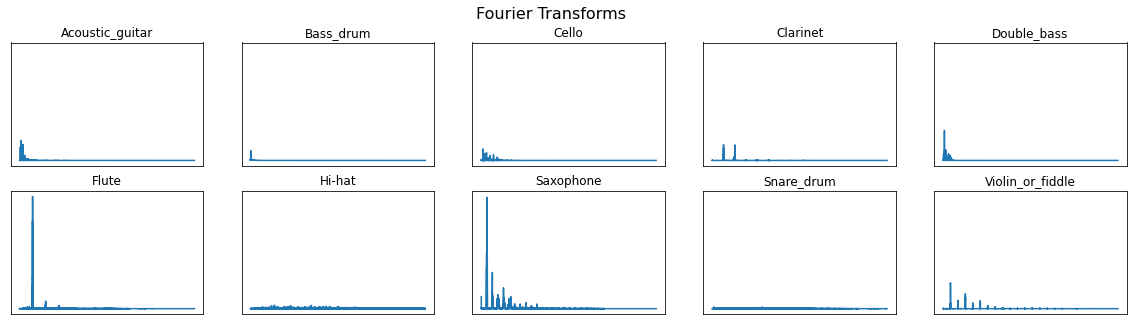

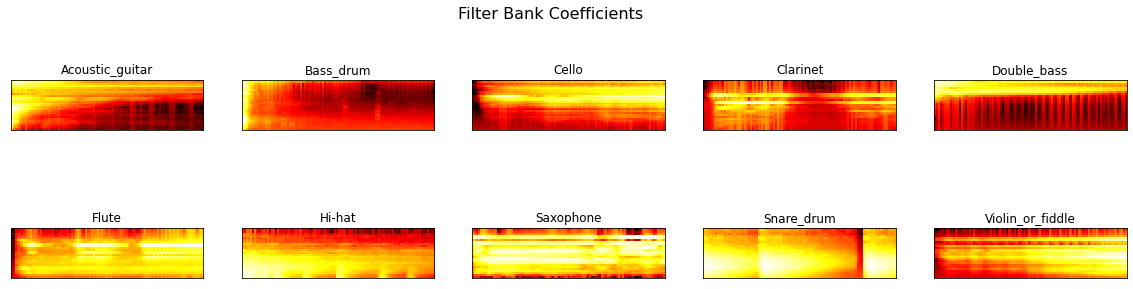

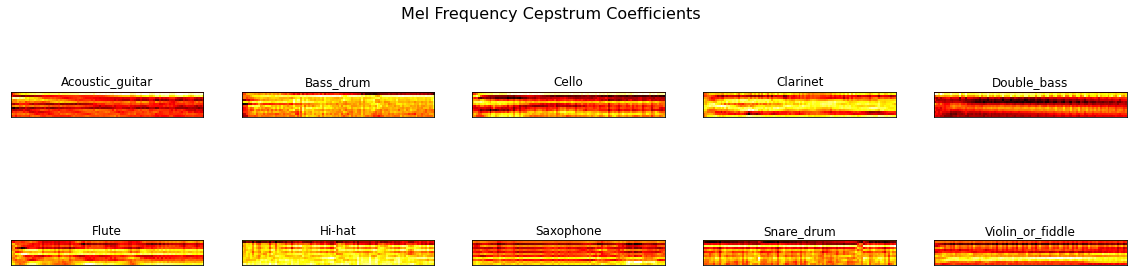

In [1]:
import tensorflow as tf
import os
from scipy.io import wavfile
from numba import cuda
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from ipynb.fs.full.instrumentsPreprocessing import calc_fft
import pickle
from keras.callbacks import ModelCheckpoint
from ipynb.fs.full.cfg import Config

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5



In [ ]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True

In [ ]:
K.clear_session()

In [ ]:
cuda.select_device(0)
cuda.close()

In [5]:
config = Config(mode='conv')

In [ ]:
!pip install ipynb

In [6]:
def check_data():
    if os.path.isfile(config.p_path):
        
        print('Loading existing data for {} model'. format(config.mode))
        with open(config.p_path,'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [7]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        print("reading temp data:")
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min,_max = float('inf'),-float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate,wav = wavfile.read('./cleaned/' + file)
        label = df.at[file,'label']
        rand_index = np.random.randint(0,wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
        _min = min(np.amin(X_sample),_min)
        _max=max(np.amax(X_sample),_max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    
    X,y = np.array(X), np.array(y)
    X =(X -_min) /(_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0],X.shape[1], X.shape[2],1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y,num_classes=10)
    config.data = (X,y)
    with open(config.p_path,'wb') as handle:
        pickle.dump(config,handle,protocol=2)
    
    return X,y

In [8]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same', input_shape=input_shape))
    model.add(Conv2D(32,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same'))
    model.add(Conv2D(64,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same'))
    model.add(Conv2D(128,(3,3), activation = 'relu', strides=(1,1),
                    padding ='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(type(model))
    return model

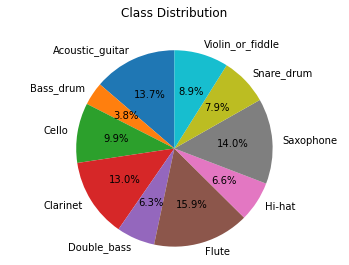

In [9]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('./cleaned/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist /class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)



fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [10]:
print(choices)
print(type (choices))

Violin_or_fiddle
<class 'str'>


In [11]:
# if config.mode == 'conv':
x,y = build_rand_feat()
y_flat = np.argmax(y,axis=1)
input_shape = (x.shape[1], x.shape[2],1)
conv_model = get_conv_model()
# elif config.mode == 'time':
#     x,y = build_rand_feat()
#     y_flat = np.argmax(y,axis=1)
#     input_shape=(x.shape[1], x.shape[2])
#     model = get_recurrent_model()

Loading existing data for conv model
reading temp data:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 4, 128)         0         
________________________________________________________________

In [12]:
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)

C:\Users\DAVID\anaconda3\envs\cos700Research\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[5 4 5 ... 3 5 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [ ]:
checkpoint  = ModelCheckpoint(config.model_path, monitor='val_acc',verbose=1, mode='max', save_best_only=True
                              , save_weights_only=False,period=1)

In [13]:
conv_model.fit(x,y,epochs=10, batch_size=32, shuffle=True, class_weight=class_weight, validation_split=0.1)

Train on 27399 samples, validate on 3045 samples
Epoch 1/10
27399/27399 [==============================] - 8s 276us/step - loss: 1.1208 - acc: 0.5979 - val_loss: 0.6834 - val_acc: 0.7609
Epoch 2/10
27399/27399 [==============================] - 4s 147us/step - loss: 0.6046 - acc: 0.7856 - val_loss: 0.4632 - val_acc: 0.8397
Epoch 3/10
27399/27399 [==============================] - 4s 147us/step - loss: 0.4577 - acc: 0.8369 - val_loss: 0.3523 - val_acc: 0.8772
Epoch 4/10
27399/27399 [==============================] - 4s 149us/step - loss: 0.3746 - acc: 0.8645 - val_loss: 0.3075 - val_acc: 0.8877
Epoch 5/10
27399/27399 [==============================] - 4s 145us/step - loss: 0.3280 - acc: 0.8794 - val_loss: 0.2669 - val_acc: 0.9061
Epoch 6/10
27399/27399 [==============================] - 4s 146us/step - loss: 0.2953 - acc: 0.8919 - val_loss: 0.2279 - val_acc: 0.9192
Epoch 7/10
27399/27399 [==============================] - 4s 145us/step - loss: 0.2549 - acc: 0.9076 - val_loss: 0.2469 - v

In [14]:
conv_model.save(config.model_path)

In [ ]:
x.shape
df.head()